In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
# load in the data
genotypes = pd.read_csv('/content/drive/My Drive/comp_gen/Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('/content/drive/My Drive/comp_gen/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [4]:
def calculate_maf(df):
    # Calculate minor allele frequency
    maf = df.apply(lambda x: min(x.mean(), 1-x.mean()), axis=0)
    return maf

def ld_pruning(df, threshold=0.5):
    # Calculate correlation matrix
    corr = df.corr()
    # Identify pairs of SNPs with correlation greater than the threshold
    # Avoid double removal and self-comparison (i.e., diagonal elements)
    to_remove = set()
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i, j] > threshold:
                to_remove.add(corr.columns[j])
    return df.drop(columns=to_remove)

In [5]:
# Apply MAF filtering
maf = calculate_maf(genotypes)
maf_threshold = 0.01  # Set MAF threshold
genotypes_filtered = genotypes.loc[:, maf >= maf_threshold]

# Apply LD pruning
genotypes_pruned = ld_pruning(genotypes_filtered, threshold=0.5)

In [6]:
# 'genotypes' and 'phenotype' are already loaded and aligned by their indices
# now we check for missing data
imputer = SimpleImputer(strategy='median')
genotypes_imputed = pd.DataFrame(imputer.fit_transform(genotypes_pruned), columns=genotypes_pruned.columns)
phenotype_imputed = pd.DataFrame(imputer.fit_transform(phenotype), columns=phenotype.columns)

# Scale the data
scaler = StandardScaler()
genotypes_scaled = pd.DataFrame(scaler.fit_transform(genotypes_imputed), columns=genotypes_pruned.columns)

# Check for any remaining NaNs or infinities
genotypes_scaled = genotypes_scaled.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
phenotype_scaled = pd.DataFrame(scaler.fit_transform(phenotype_imputed), columns=phenotype.columns)

In [7]:
# Extract the AVGROW97 column from the phenotype dataframe
y = phenotype_scaled['AVGROW97']
# Construct X from the genotype dataframe
X = genotypes_scaled

# Determine the number of samples (rows) and features (columns)
num_samples, num_features = X.shape

print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 291
Number of features: 243


In [8]:
# Perform PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(genotypes_scaled)

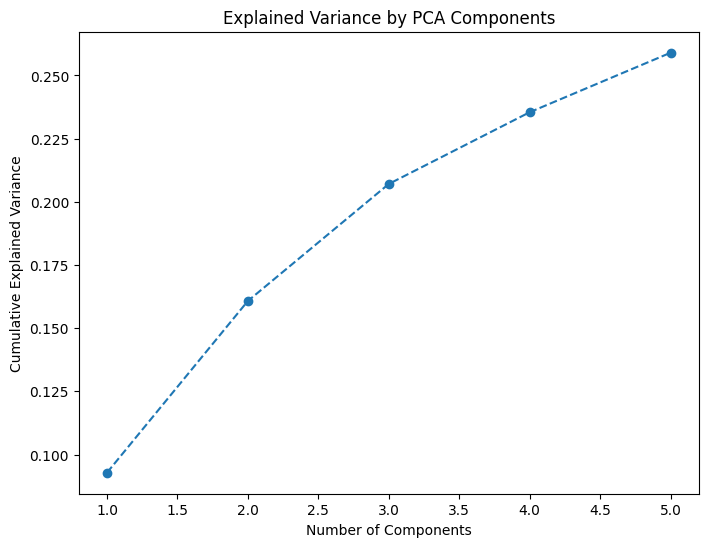

In [9]:
# Plot explained variance by PCA components
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Lasso Regression Feature Selection with Cross-Validation

In [10]:
from sklearn.linear_model import LassoCV

# Lasso with built-in cross-validation to choose the best alpha
lasso = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X, y)
selected_features_lasso = np.where(lasso.coef_ != 0)[0]
# save selected features from Lasso
np.savetxt("selected_features_lasso.txt", selected_features_lasso, fmt='%d')
# save Lasso coefficients
np.savetxt("lasso_coefficients.txt", lasso.coef_, fmt='%f')

In [11]:
from google.colab import files

# Download the files to your local system
files.download('selected_features_lasso.txt')
files.download('lasso_coefficients.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>